# Image Segmentation

- suppose you want to know where an object is located in the image, the shape of that object, which pixel belongs to which object, etc. In this case you will want to segment the image, i.e., each pixel of the image is given a label. 

- Classify each and every pixel in the image

- Train a neural network to predict the mask of the image. Here we use a modified U-Net

- This helps in better understanding at the lower level. 

# Example of IIIT Pet Dataset

The dataset consists of images, their corresponding labels, and pixel-wise masks. The masks are basically labels for each pixel. Each pixel is given one of three categories :

- Class 1 : Pixel belonging to the pet.
- Class 2 : Pixel bordering the pet.
- Class 3 : None of the above/ Surrounding pixel.


In [1]:
! pip install -q git+https://github.com/tensorflow/examples.git

In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [4]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0.incompleteKYH56O/oxford_iiit_pet-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0.incompleteKYH56O/oxford_iiit_pet-test.tfrecord
Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0. Subsequent calls will reuse this data.


 - For the sake of convenience, let's subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

# Data Wrangling

In [0]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.
    input_mask -= 1
    return input_image, input_mask

In [0]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    # Probabilistically flipping
    if (tf.random.uniform(()) > 0.5):
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask


In [0]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [0]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [0]:
train = dataset['train'].map(load_image_train)
test = dataset['test'].map(load_image_test) 

In [0]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(BUFFER_SIZE)
test_dataset = test.batch(BATCH_SIZE)

In [0]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

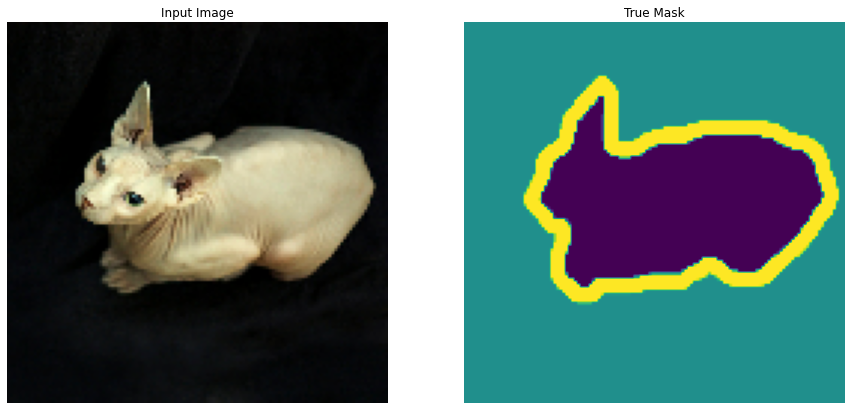

In [12]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])


# Define the model

The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. Thus, the encoder for this task will be a pretrained MobileNetV2 model, whose intermediate outputs will be used, and the decoder will be the upsample block already implemented in TensorFlow Examples in the Pix2pix tutorial.

The reason to output three channels is because there are three possible labels for each pixel. Think of this as multi-classification where each pixel is being classified into three classes.

In [0]:
OUTPUT_CHANNELS = 3

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False)

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

In [0]:
layers = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [0]:
down_stack.trainable = False

In [0]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [0]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


In [0]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['acc'])

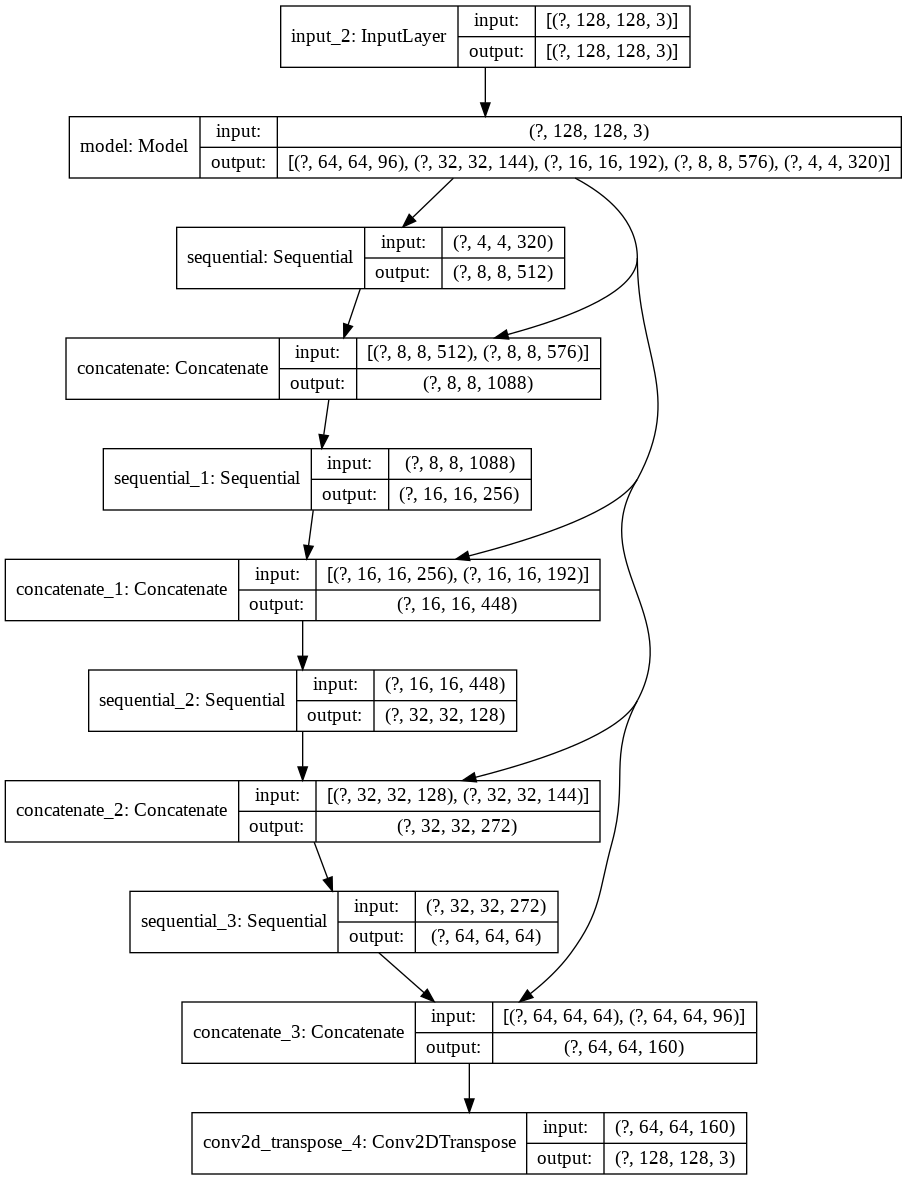

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [0]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


In [0]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

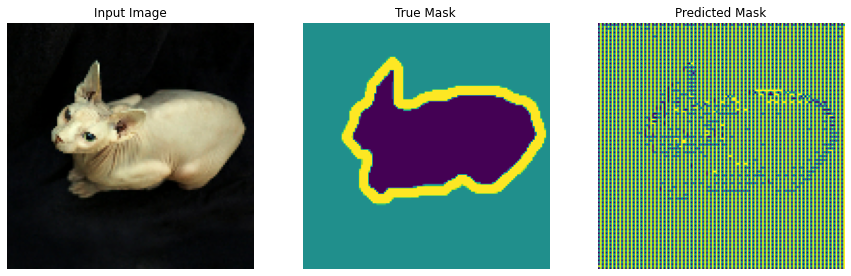

In [24]:
show_predictions()

In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_display(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print("Sample predictions at epoch number: %d"%(epoch))

In [26]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])


Train for 57 steps, validate for 11 steps
Epoch 1/20
57/57 [==============================] - 23s 412ms/step - loss: 0.5545 - acc: 0.7747 - val_loss: 0.6381 - val_acc: 0.7955
Epoch 2/20
57/57 [==============================] - 18s 308ms/step - loss: 0.3089 - acc: 0.8736 - val_loss: 0.3761 - val_acc: 0.8577
Epoch 3/20
57/57 [==============================] - 16s 289ms/step - loss: 0.2821 - acc: 0.8833 - val_loss: 0.3142 - val_acc: 0.8730
Epoch 4/20
57/57 [==============================] - 16s 289ms/step - loss: 0.2632 - acc: 0.8899 - val_loss: 0.3009 - val_acc: 0.8785
Epoch 5/20
57/57 [==============================] - 16s 288ms/step - loss: 0.2559 - acc: 0.8924 - val_loss: 0.3016 - val_acc: 0.8773
Epoch 6/20
57/57 [==============================] - 16s 288ms/step - loss: 0.2463 - acc: 0.8956 - val_loss: 0.2978 - val_acc: 0.8810
Epoch 7/20
57/57 [==============================] - 16s 289ms/step - loss: 0.2371 - acc: 0.8991 - val_loss: 0.2915 - val_acc: 0.8833
Epoch 8/20
57/57 [=========

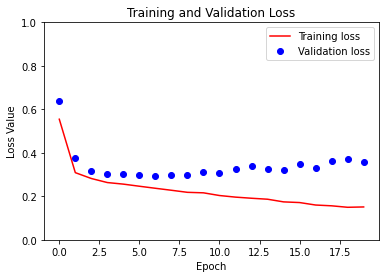

In [27]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()
